In [1]:
import rasterio
import numpy as np
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.stats import binned_statistic
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon, mapping, box
from shapely.ops import unary_union, transform
import rasterio.features
import rasterio.mask
import os
import pyproj

In [2]:
def clip_dem_by_bounds(source_path, destination_path, clip_bounds):
    """
    Clips a raster file to a given bounding box.

    Args:
        source_path (str): Path to the original DEM file.
        destination_path (str): Path to save the new, clipped DEM file.
        clip_bounds (list): A list defining the bounding box in the format
                            [min_longitude, min_latitude, max_longitude, max_latitude].
                            Coordinates are in EPSG:4326 (degrees).
    """
    print(f"Clipping {source_path}...")
    
    # Create a shapely geometry from the bounding box
    bbox = box(*clip_bounds)
    geometries = [bbox]

    with rasterio.open(source_path) as src:
        # Clip the raster using the geometry
        out_image, out_transform = rasterio.mask.mask(src, geometries, crop=True)
        out_meta = src.meta.copy()

    # Update the metadata of the new, clipped raster
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Write the clipped raster to the destination file
    with rasterio.open(destination_path, "w", **out_meta) as dest:
        dest.write(out_image)
        
    print(f"DEM successfully clipped. File saved to: {destination_path}")

def _get_utm_epsg(lon, lat):
    """Calculates the UTM EPSG code for a given longitude and latitude."""
    zone_number = math.floor((lon + 180) / 6) + 1
    if lat >= 0:
        return f'EPSG:{32600 + zone_number}'
    else:
        return f'EPSG:{32700 + zone_number}'

def _calculate_true_slope(src_dataset):
    """
    Calculates slope by temporarily reprojecting the DEM to a suitable UTM zone in memory.
    The final slope raster is warped back to match the source dataset's grid.
    """
    center_lon = (src_dataset.bounds.left + src_dataset.bounds.right) / 2
    center_lat = (src_dataset.bounds.top + src_dataset.bounds.bottom) / 2
    utm_crs = _get_utm_epsg(center_lon, center_lat)
    print(f"Temporarily reprojecting to {utm_crs} for slope calculation...")
    dst_transform, width, height = calculate_default_transform(
        src_dataset.crs, utm_crs, src_dataset.width, src_dataset.height, *src_dataset.bounds)
    projected_dem = np.zeros((height, width), dtype=np.float32)
    reproject(
        source=rasterio.band(src_dataset, 1), destination=projected_dem,
        src_transform=src_dataset.transform, src_crs=src_dataset.crs,
        dst_transform=dst_transform, dst_crs=utm_crs, resampling=Resampling.bilinear)
    pixel_size_x = dst_transform.a
    pixel_size_y = -dst_transform.e
    gy, gx = np.gradient(projected_dem)
    slope_rad = np.arctan(np.sqrt((gx / pixel_size_x)**2 + (gy / pixel_size_y)**2))
    projected_slope = np.degrees(slope_rad)
    final_slope = np.zeros_like(src_dataset.read(1), dtype=np.float32)
    reproject(
        source=projected_slope, destination=final_slope,
        src_transform=dst_transform, src_crs=utm_crs,
        dst_transform=src_dataset.transform, dst_crs=src_dataset.crs,
        resampling=Resampling.bilinear)
    print("Slope calculation and warping complete.")
    return final_slope

def interactive_classify_and_slope(dem_path, classified_output_path, slope_output_path, num_bins=1000):
    """
    Main function to classify DEM and calculate slope. Includes a 3-plot interactive dashboard.
    """
    with rasterio.open(dem_path) as src:
        dem = src.read(1, masked=True)
        profile = src.profile
        slope_deg = _calculate_true_slope(src)
        
        print(f"Saving slope raster to {slope_output_path}...")
        slope_profile = profile.copy()
        slope_profile.update(dtype=rasterio.float32, nodata=np.nan, compress='lzw')
        slope_deg[dem.mask] = np.nan
        with rasterio.open(slope_output_path, 'w', **slope_profile) as dst:
            dst.write(slope_deg.astype(rasterio.float32), 1)
        print("Slope raster saved successfully.")
        
        # Hypsometric analysis
        pixel_area = profile['transform'].a * -profile['transform'].e
        min_elev, max_elev = dem.min(), dem.max()
        elev_levels = np.linspace(min_elev, max_elev, num_bins)
        cumulative_area = np.array([np.sum(dem <= level) * pixel_area for level in elev_levels])
        d_area = np.gradient(cumulative_area)
        d_elev = np.gradient(elev_levels)
        dAdz = d_area / d_elev
        dAdz_smooth = np.convolve(dAdz, np.ones(5)/5, mode='same')

        # Calculate Binned Average Slope
        valid_mask = ~dem.mask
        elevation_values = dem.data[valid_mask]
        slope_values = slope_deg[valid_mask]
        
        slope_means, bin_edges, _ = binned_statistic(
            x=elevation_values, values=slope_values, statistic='mean', bins=200
        )
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Create 3-Plot Interactive Dashboard
        fig = make_subplots(
            rows=1, cols=3, shared_yaxes=True,
            subplot_titles=("Hypsometric Curve", "Derivative (dA/dz)", "Avg. Slope vs. Elevation")
        )
        fig.add_trace(go.Scatter(x=cumulative_area, y=elev_levels, mode='lines', name='Area'), row=1, col=1)
        fig.add_trace(go.Scatter(x=dAdz_smooth, y=elev_levels, mode='lines', name='dA/dz'), row=1, col=2)
        fig.add_trace(go.Scatter(x=slope_means, y=bin_centers, mode='lines', name='Avg. Slope'), row=1, col=3)
        
        fig.update_layout(height=600, width=1500, title_text="Interactive Hypsometric and Slope Analysis", template="plotly_white", hovermode='y unified')
        fig.update_xaxes(showspikes=True, spikemode='across', spikethickness=1, spikedash='dot')
        fig.update_yaxes(showspikes=True, spikemode='across', spikethickness=1, spikedash='dot', title_text="Elevation (m)", showgrid=True, gridwidth=1, gridcolor='LightGray')
        fig.update_xaxes(title_text="Cumulative Area (m^2)", row=1, col=1, showgrid=True, gridwidth=1, gridcolor='LightGray')
        fig.update_xaxes(title_text="Rate of Area Change (m^2/m)", row=1, col=2, showgrid=True, gridwidth=1, gridcolor='LightGray')
        fig.update_xaxes(title_text="Average Slope (degrees)", row=1, col=3, showgrid=True, gridwidth=1, gridcolor='LightGray')
        
        fig.show()

        # User input and classification
        thresholds_str = input("Enter elevation thresholds, separated by commas (e.g., 0, -200, -1500): ")
        try:
            thresholds = [float(t.strip()) for t in thresholds_str.split(',')]
            thresholds.sort(reverse=True) 
        except ValueError:
            print("Invalid input. Please enter numeric values only.")
            return
        
        print(f"Using the following {len(thresholds)} thresholds: {thresholds}")
        conditions = []
        choices = []
        for i in range(len(thresholds)):
            if i == 0:
                conditions.append(dem > thresholds[i])
            else:
                conditions.append((dem > thresholds[i]) & (dem <= thresholds[i-1]))
            choices.append(thresholds[i])
        
        default_choice = thresholds[-1] 
        classified_raster = np.select(conditions, choices, default=default_choice)
        classified_raster[dem.mask] = np.nan
        
        class_profile = profile.copy()
        class_profile.update(dtype=rasterio.float32, nodata=np.nan, compress='lzw')
        with rasterio.open(classified_output_path, 'w', **class_profile) as dst:
            dst.write(classified_raster.astype(rasterio.float32), 1)
        print(f"Classification complete! Files saved.")

def _resample_geometry_vertices(geom, spacing):
    """
    Resamples the vertices of a Polygon or MultiPolygon, correctly handling holes.
    """
    if geom.is_empty or spacing <= 0:
        return geom
        
    if geom.geom_type == 'Polygon':
        exterior_ring = geom.exterior
        if exterior_ring.length < spacing * 3:
            return geom # If the main boundary is too small, return original
        
        num_vertices_ext = max(3, int(round(exterior_ring.length / spacing)))
        distances_ext = np.linspace(0, exterior_ring.length, num_vertices_ext)
        resampled_exterior = [exterior_ring.interpolate(distance) for distance in distances_ext]

        resampled_interiors = []
        for interior_ring in geom.interiors:
            if interior_ring.length < spacing * 3:
                resampled_interiors.append(list(interior_ring.coords)) # Keep small holes
                continue

            num_vertices_int = max(3, int(round(interior_ring.length / spacing)))
            distances_int = np.linspace(0, interior_ring.length, num_vertices_int)
            resampled_interior = [interior_ring.interpolate(distance) for distance in distances_int]
            resampled_interiors.append(resampled_interior)
        
        return Polygon(resampled_exterior, resampled_interiors)

    elif geom.geom_type == 'MultiPolygon':
        resampled_polygons = [_resample_geometry_vertices(poly, spacing) for poly in geom.geoms]
        return MultiPolygon([p for p in resampled_polygons if p and not p.is_empty])
        
    return geom

def reclassify_and_vectorize(classified_raster_path, regime_raster_path, regime_shapefile_path, vertex_spacing_m=500):
    """
    Interactively reclassifies a raster and creates both a final regime raster
    and a corresponding shapefile with smoothed, valid polygons for each regime.

    Args:
        classified_raster_path (str): Path to the classified raster with float values.
        regime_raster_path (str): Path to save the final reclassified regime raster.
        regime_shapefile_path (str): Path to save the final regime shapefile.
        vertex_spacing_m (float, optional): The target spacing in meters for polygon
                                             vertices. Defaults to 500.
    """
    print("\n Step 2: Interactive Regime Reclassification and Vectorization")
    
    with rasterio.open(classified_raster_path) as src:
        profile = src.profile
        data = src.read(1, masked=True)
        unique_classes = np.unique(data[~data.mask])
        print(f"Found the following elevation classes in the raster: {unique_classes}")

    # Get reclassification rules from user
    regime_rules = {}
    regime_names = {
        1: 'over land (ol)',
        2: 'non-eddy regime (nr)',
        3: 'transition zone (tz)',
        4: 'eddy regime (er)'
    }
    
    print("\nEnter the elevation range for each regime.")
    print("Example: For a range from -23 to -200, enter '-23, -200'")

    for code, name in regime_names.items():
        while True:
            try:
                bounds_str = input(f"Enter the lowest and highest values for '{name}': ")
                bounds = [float(b.strip()) for b in bounds_str.split(',')]
                if len(bounds) != 2: raise ValueError("Please enter exactly two values.")
                regime_rules[code] = (min(bounds), max(bounds))
                break
            except ValueError as e:
                print(f"Invalid input. {e}. Please try again.")

    # Reclassify the raster using the new rules
    conditions = [
        (data >= rule[0]) & (data <= rule[1]) for code, rule in sorted(regime_rules.items())
    ]
    choices = list(sorted(regime_rules.keys()))
    
    reclassified_data = np.select(conditions, choices, default=0).astype(np.uint8)
    reclassified_data[data.mask] = 0 # Apply nodata mask

    # Save the final raster with embedded labels
    profile.update(dtype=rasterio.uint8, count=1, nodata=0, compress='lzw')

    print(f"\nSaving final regime raster to {regime_raster_path}...")
    with rasterio.open(regime_raster_path, 'w', **profile) as dst:
        dst.write(reclassified_data, 1)
        dst.update_tags(CLASS_LABELS=str(regime_names))
        dst.set_band_description(1, 'Seafloor Regimes')
    print("Regime raster saved successfully.")

    # Part 2: Vectorize the reclassified raster
    print(f"\nNow generating shapefile with {vertex_spacing_m}m vertex spacing...")
    
    # Setup projections for accurate resampling
    source_crs = pyproj.CRS(profile['crs'])
    center_lon, center_lat = profile['transform'] * (profile['width'] / 2, profile['height'] / 2)
    utm_crs = pyproj.CRS(_get_utm_epsg(center_lon, center_lat))
    project_to_utm = pyproj.Transformer.from_crs(source_crs, utm_crs, always_xy=True).transform
    project_to_gcs = pyproj.Transformer.from_crs(utm_crs, source_crs, always_xy=True).transform

    # Define the shapefile schema
    schema = {
        'geometry': 'MultiPolygon',
        'properties': {'regime_id': 'int', 'regime_name': 'str'},
    }

    with fiona.open(
        regime_shapefile_path, 'w', 
        driver='ESRI Shapefile', 
        crs=source_crs.to_wkt(), 
        schema=schema
    ) as collection:
        for code, name in sorted(regime_names.items()):
            print(f"  -> Processing regime: '{name}'")
            
            class_mask = (reclassified_data == code).astype(np.uint8)
            shapes = rasterio.features.shapes(class_mask, transform=profile['transform'])
            polygons = [shape(geom) for geom, val in shapes if val == 1]
            
            if not polygons:
                print(f"     No features found for '{name}'. Skipping.")
                continue

            merged_gcs = unary_union(polygons)
            merged_utm = transform(project_to_utm, merged_gcs)
            resampled_utm = _resample_geometry_vertices(merged_utm, spacing=vertex_spacing_m)
            resampled_gcs = transform(project_to_gcs, resampled_utm)

            if not resampled_gcs.is_valid:
                print(f"     Warning: Repaired invalid geometry for '{name}'.")
                resampled_gcs = resampled_gcs.buffer(0)
            if resampled_gcs and not resampled_gcs.is_empty:
                if resampled_gcs.geom_type == 'Polygon':
                    final_geom = MultiPolygon([resampled_gcs])
                else:
                    final_geom = resampled_gcs
                    
                collection.write({
                    'geometry': mapping(final_geom),
                    'properties': {'regime_id': code, 'regime_name': name},
                })

    print(f"\nShapefile creation complete! Saved to: {regime_shapefile_path}")
    print("Workflow complete!")

In [3]:
#### This is how you run it:

# Define Inputs and Outputs
input_dem = r'PATH/gebco_2024_n56.0_s5.0_w-100.0_e-50.0.tif'

output_classified = r'PATH/classified_raster.tif'
output_slope = r'PATH/slope_raster.tif'

output_regime_raster = r'PATH/regime_raster.tif'
output_regime_shapefile = r'PATH/regimes.shp'

In [4]:
#Values used:
#10, 0, -50, -100, -200, -300, -400, -512, -650,-800, -950, -2600, -3500, -4200,-5500,-6500

Temporarily reprojecting to EPSG:32618 for slope calculation...
Slope calculation and warping complete.
Saving slope raster to C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\AutoOceanMesh\RegimeIdentification/outputs/slope_raster.tif...
Slope raster saved successfully.


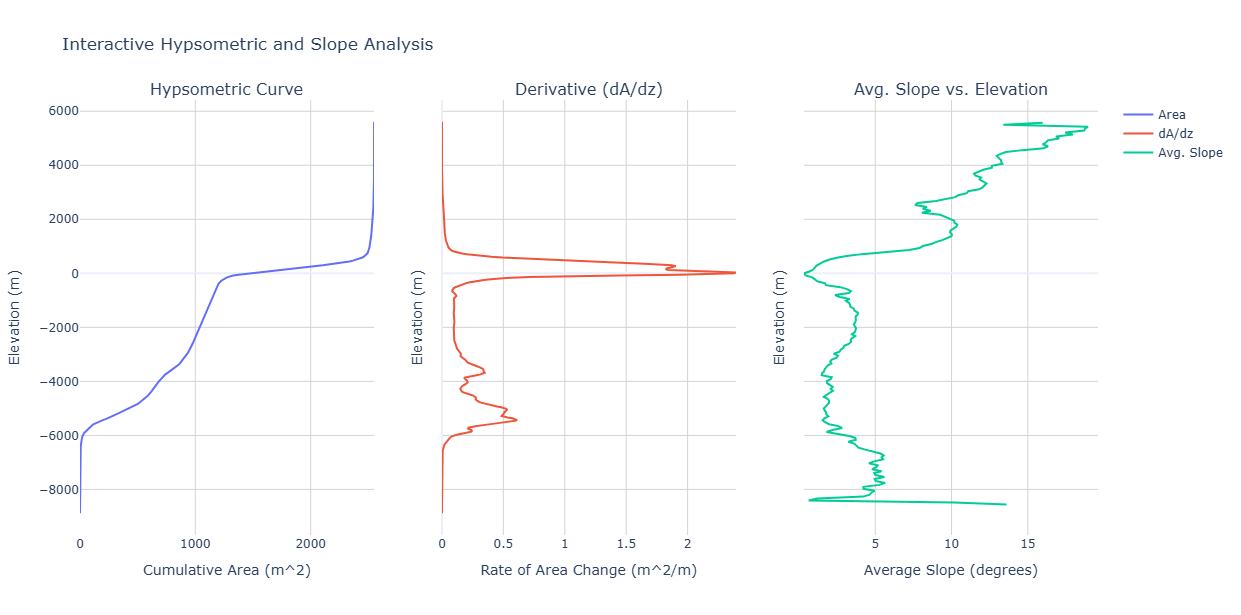

Enter elevation thresholds, separated by commas (e.g., 0, -200, -1500):  10, 0, -50, -100, -200, -300, -400, -512, -650,-800, -950, -2600, -3500, -4200,-5500,-6500


Using the following 16 thresholds: [10.0, 0.0, -50.0, -100.0, -200.0, -300.0, -400.0, -512.0, -650.0, -800.0, -950.0, -2600.0, -3500.0, -4200.0, -5500.0, -6500.0]
Classification complete! Files saved.


In [4]:
# Step 1: Elevation Classification
interactive_classify_and_slope(
    dem_path=input_dem,
    classified_output_path=output_classified,
    slope_output_path=output_slope,
    # num_bins=500
)

In [5]:
# Example: For a range from -23 to -200, enter '-23, -200'
# Enter the shallowest and deepest values for 'over land (ol)':  0.,10.
# Enter the shallowest and deepest values for 'non-eddy regime (nr)':  -50.,0.
# Enter the shallowest and deepest values for 'transition zone (tz)':  -400.,-50
# Enter the shallowest and deepest values for 'eddy regime (er)':  -9999,-400

In [7]:
# Step 2: Regime Reclassification AND Vectorization
reclassify_and_vectorize(
    classified_raster_path=output_classified,
    regime_raster_path=output_regime_raster,
    regime_shapefile_path=output_regime_shapefile,
    vertex_spacing_m=1000
)


--- Step 2: Interactive Regime Reclassification and Vectorization ---
Found the following elevation classes in the raster: [-6500.0 -5500.0 -4200.0 -3500.0 -2600.0 -950.0 -800.0 -650.0 -512.0
 -400.0 -300.0 -200.0 -100.0 -50.0 0.0 10.0]

Enter the elevation range for each regime.
Example: For a range from -23 to -200, enter '-23, -200'


Enter the lowest and highest values for 'over land (ol)':  0,100
Enter the lowest and highest values for 'non-eddy regime (nr)':  -50,0
Enter the lowest and highest values for 'transition zone (tz)':  -400,-50
Enter the lowest and highest values for 'eddy regime (er)':  -9999,-400



Saving final regime raster to C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\AutoOceanMesh\RegimeIdentification/outputs/regime_raster.tif...
Regime raster saved successfully.

Now generating shapefile with 1000m vertex spacing...
  -> Processing regime: 'over land (ol)'
  -> Processing regime: 'non-eddy regime (nr)'
  -> Processing regime: 'transition zone (tz)'
  -> Processing regime: 'eddy regime (er)'

Shapefile creation complete! Saved to: C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\AutoOceanMesh\RegimeIdentification/outputs/regimes.shp
Workflow complete!
